In [1]:
#import all necessary packages
from sklearn.model_selection import train_test_split
import math
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pickle
import keras_nlp
import keras
import os


2024-09-28 11:36:50.293565: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-28 11:36:50.293667: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-28 11:36:50.416176: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
#set some env variables
os.environ["KERAS_BACKEND"] = "jax"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="False"

In [12]:
class Config:
    seed = 42  # Random seed
    preset = "deberta_v3_small_en" # Name of the pretrained model to be used
    sequence_length = 1024  # Input sequence length
    epochs = 20 # Training epochs
    batch_size =10  # Batch size
    test_size = 0.2 #test split ratio 
    scheduler = 'cosine'  # Learning rate scheduler
    patience=2 #used for early stopping
    base_path ="/kaggle/input/" 
    data_folder = "learning-agency-lab-automated-essay-scoring-2/" #change this depending on your running env

Attaching 'tokenizer.json' from model 'keras/deberta_v3/keras/deberta_v3_small_en/2' to your Kaggle notebook...
Attaching 'tokenizer.json' from model 'keras/deberta_v3/keras/deberta_v3_small_en/2' to your Kaggle notebook...
Attaching 'assets/tokenizer/vocabulary.spm' from model 'keras/deberta_v3/keras/deberta_v3_small_en/2' to your Kaggle notebook...


## 1.Exploratory Data Analysis

## 1.1 Read the Data

In [4]:
df_train = pd.read_csv(f"{Config.base_path}{Config.data_folder}train.csv")
print(f"We have about {df_train.shape[0]:,} essays")
df_train.head()

We have about 17,307 essays


,essay_id,full_text,score
0,000d118,Many people have car where they live. The thin...,3
1,000fe60,I am a scientist at NASA that is discussing th...,3
2,001ab80,People always wish they had the same technolog...,4
3,001bdc0,"We all heard about Venus, the planet without a...",4
4,002ba53,"Dear, State Senator\n\nThis is a letter to arg...",3


## 1.2 Devide the data 

In [5]:
#create our test set
train_df, valid_df = train_test_split(df_train, test_size=Config.test_size, stratify=df_train["score"],random_state=Config.seed)

## 1.3 Explore the data

What's the score distribution across the essays?

<Axes: xlabel='score', ylabel='count'>

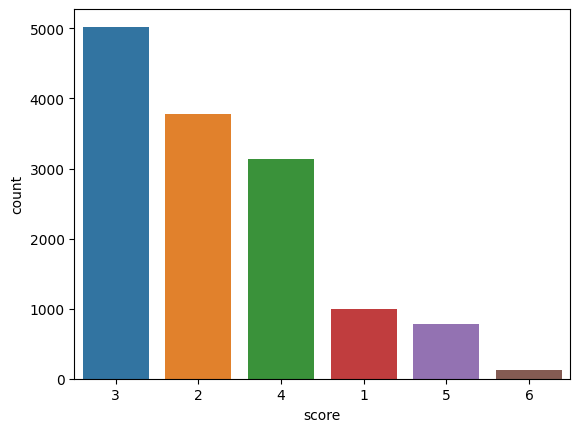

In [6]:
#visualize the score distribution across the essays
sns.countplot(data=train_df,
            x="score",
            order=train_df["score"].value_counts().index)

Is there a link between score and essay length or number of words?

<Axes: xlabel='score', ylabel='number_of_tokens'>

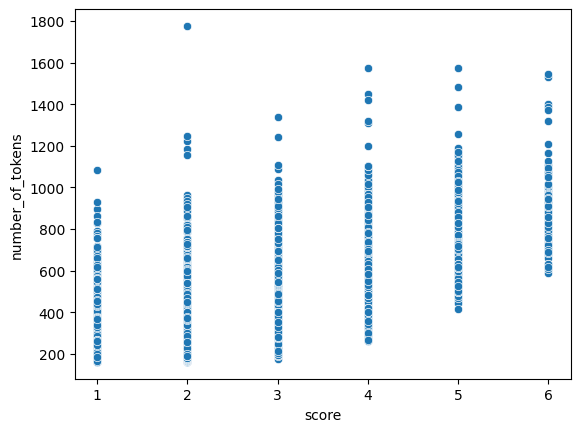

In [13]:
#compute token length of each essay across the dataset
train_df["number_of_tokens"] = train_df["full_text"].apply(lambda x:Config.tokenizer(x).shape[0])

#plot the scatter plot

sns.scatterplot(data=train_df,x="score",y="number_of_tokens")

In [14]:
print(f"The Pearson correlation is {np.corrcoef(train_df['number_of_tokens'],train_df['score'])}")

The Pearson correlation is [[1.         0.68715231]
 [0.68715231 1.        ]]


In [16]:
train_df[["score","number_of_tokens"]].groupby("score").describe()

number_of_tokens                                                      \
                 count        mean         std    min    25%    50%    75%   
score                                                                        
1               1001.0  314.126873  125.129361  162.0  227.0  276.0  369.0   
2               3778.0  302.660932  112.691517  162.0  228.0  275.0  344.0   
3               5024.0  414.338774  118.211991  176.0  332.0  395.0  475.0   
4               3141.0  555.350207  127.408039  262.0  468.0  537.0  619.0   
5                776.0  737.222938  156.368698  417.0  625.0  712.5  826.0   
6                125.0  892.280000  177.442930  590.0  765.0  872.0  964.0   

               
          max  
score          
1      1086.0  
2      1776.0  
3      1340.0  
4      1574.0  
5      1575.0  
6      1544.0

There is a high positive correlation between the length of the essay (number of tokens) and the score the student gets. </br> This is also illustrated in the table above, where the greater the score the greater the median and mean number of token in the essay.

What's the distribution of tokens ? </br>
Useful to determine the context window (Max sequence length) of our LLM.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 1600x1600 with 0 Axes>

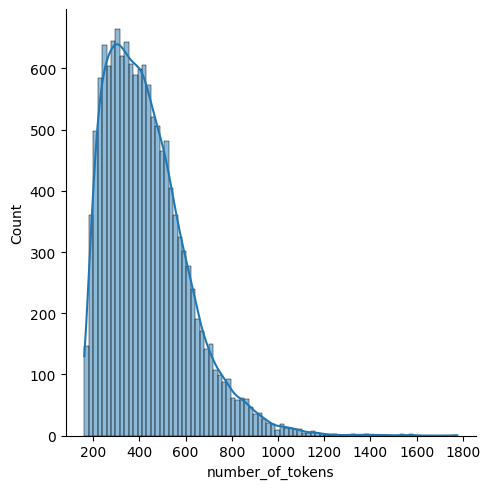

In [17]:
#compute token length of each essay across the dataset
train_df["number_of_tokens"] = train_df["full_text"].apply(lambda x:Config.tokenizer(x).shape[0])

#define a figure object of custom dimensions
plt.figure(figsize=(8,8),dpi=200)

#plot the histogram
sns.displot(data=train_df,x="number_of_tokens",kind="hist",kde=True)

In [18]:
train_df["number_of_tokens"].describe()

count    13845.000000
mean       431.022535
std        176.826422
min        162.000000
25%        296.000000
50%        403.000000
75%        529.000000
max       1776.000000
Name: number_of_tokens, dtype: float64

# 2.Prepare the data

## Define some useful functions

In [19]:
preprocessor = keras_nlp.models.DebertaV3Preprocessor.from_preset(
    preset=Config.preset, # Name of the model
    sequence_length=Config.sequence_length, # Max sequence length, will be padded if shorter
)

def preprocess_fn(text, label=None,preprocessor=preprocessor):
    """
    Preprocesses the input text using a predefined `preprocessor` function and optionally returns the label.

    Args:
        text (str): The input text to be preprocessed.
        label (any, optional): An optional label associated with the text. If provided, both the 
                               preprocessed text and label are returned. Defaults to None.

    Returns:
        tuple or str: If `label` is provided, returns a tuple `(preprocessed_text, label)`. 
                      Otherwise, returns only the `preprocessed_text`.
    """
    text = preprocessor(text)  # Preprocess text
    return (text, label) if label is not None else text


Attaching 'tokenizer.json' from model 'keras/deberta_v3/keras/deberta_v3_small_en/2' to your Kaggle notebook...
Attaching 'tokenizer.json' from model 'keras/deberta_v3/keras/deberta_v3_small_en/2' to your Kaggle notebook...
Attaching 'assets/tokenizer/vocabulary.spm' from model 'keras/deberta_v3/keras/deberta_v3_small_en/2' to your Kaggle notebook...


In [20]:
def build_dataset(texts, labels=None, batch_size=Config.batch_size,
                  cache=True, drop_remainder=True, shuffle=1024):
    """
    Builds a TensorFlow dataset from input texts (and optional labels), with support for caching, shuffling, 
    batching, and prefetching.

    Args:
        texts (list or array-like): The input texts to be processed.
        labels (list or array-like, optional): Optional labels corresponding to the texts. If provided, the dataset 
                                               will contain both texts and labels. Defaults to None.
        batch_size (int, optional): The size of batches to be returned by the dataset. Defaults to `Config.batch_size`.
        cache (bool, optional): Whether to cache the dataset in memory for improved performance. Defaults to True.
        drop_remainder (bool, optional): Whether to drop the remainder of the last batch if it contains fewer than 
                                         `batch_size` elements. Defaults to True.
        shuffle (int or bool, optional): The buffer size for shuffling the dataset. If `False` or `0`, shuffling is 
                                         disabled. Defaults to 1024.

    Returns:
        tf.data.Dataset: A TensorFlow dataset with the following transformations applied:
                         - Text preprocessing using `preprocess_fn`.
                         - Optional caching and shuffling.
                         - Batching according to `batch_size` and `drop_remainder`.
                         - Prefetching for efficient data loading.

    Notes:
        - The dataset is automatically tuned using TensorFlow's `AUTOTUNE` to optimize performance.
        - If `shuffle` is enabled, the dataset will be shuffled with a buffer of the specified size.
        - The dataset options enable non-deterministic execution for better performance during training 
          when shuffling is applied.
    """
    AUTO = tf.data.AUTOTUNE  # AUTOTUNE option
    slices = (texts,) if labels is None else (texts, labels)  # Create slices
    ds = tf.data.Dataset.from_tensor_slices(slices)  # Create dataset from slices
    ds = ds.cache() if cache else ds  # Cache dataset if enabled
    ds = ds.map(preprocess_fn, num_parallel_calls=AUTO)  # Map preprocessing function
    opt = tf.data.Options()  # Create dataset options
    if shuffle: 
        ds = ds.shuffle(shuffle, seed=Config.seed)  # Shuffle dataset if enabled
        opt.experimental_deterministic = False
    ds = ds.with_options(opt)  # Set dataset options
    ds = ds.batch(batch_size, drop_remainder=drop_remainder)  # Batch dataset
    ds = ds.prefetch(AUTO)  # Prefetch next batch
    return ds


In [21]:
def to_ordinal(y, num_classes=None, dtype="float32"):
    """Converts a class vector (integers) to an ordinal regression matrix.

    This utility encodes class vector to ordinal regression/classification
    matrix where each sample is indicated by a row and rank of that sample is
    indicated by number of ones in that row.

    Args:
        y: Array-like with class values to be converted into a matrix
            (integers from 0 to `num_classes - 1`).
        num_classes: Total number of classes. If `None`, this would be inferred
            as `max(y) + 1`.
        dtype: The data type expected by the input. Default: `'float32'`.

    Returns:
        An ordinal regression matrix representation of the input as a NumPy
        array. The class axis is placed last.
    """
    y = np.array(y, dtype="int")
    input_shape = y.shape

    # Shrink the last dimension if the shape is (..., 1).
    if input_shape and input_shape[-1] == 1 and len(input_shape) > 1:
        input_shape = tuple(input_shape[:-1])

    y = y.reshape(-1)
    if not num_classes:
        num_classes = np.max(y) + 1
    n = y.shape[0]
    range_values = np.arange(num_classes - 1)
    range_values = np.tile(np.expand_dims(range_values, 0), [n, 1])
    ordinal = np.zeros((n, num_classes - 1), dtype=dtype)
    ordinal[range_values < np.expand_dims(y, -1)] = 1
    output_shape = input_shape + (num_classes - 1,)
    ordinal = np.reshape(ordinal, output_shape)
    return ordinal

In [22]:
# Train Data
train_df["label"] = to_ordinal(train_df.score.values).tolist()
valid_df["label"] = to_ordinal(valid_df.score.values).tolist()

train_texts = train_df.full_text.tolist()  # Extract training texts
train_labels = np.array(train_df.label.tolist())  # Extract training labels

# Build training dataset
train_ds = build_dataset(
    train_texts, train_labels, batch_size=Config.batch_size, shuffle=True
)

# Valid Data
valid_texts = valid_df.full_text.tolist()  # Extract validation texts
valid_labels = np.array(valid_df.label.tolist())  # Extract validation labels

# Build validation dataset
valid_ds = build_dataset(
    valid_texts, valid_labels, batch_size=Config.batch_size, shuffle=False
)

# 5. Training 

# Use the helper functions and classes provided in the starter Guide

In [ ]:


def get_lr_callback(batch_size=Config.batch_size, mode='cos', epochs=Config.epochs, plot=False):
    """
    Returns a Keras learning rate scheduler callback that adjusts the learning rate over epochs
    according to the specified mode (cosine, exponential, or step decay). Optionally plots the learning rate schedule.

    Parameters:
    -----------
    batch_size : int, optional, default=Config.batch_size
        The batch size used in the training process, which influences the maximum learning rate.
    
    mode : str, optional, default='cos'
        The mode of the learning rate schedule. Supported modes are:
        - 'cos' : Cosine annealing.
        - 'exp' : Exponential decay.
        - 'step': Step-wise decay.
    
    epochs : int, optional, default=Config.epochs
        The total number of epochs for training, which defines the duration of the learning rate schedule.

    plot : bool, optional, default=False
        If True, a plot of the learning rate schedule will be displayed.

    Returns:
    --------
    keras.callbacks.LearningRateScheduler
        A Keras callback that schedules the learning rate at the beginning of each epoch.
    
    Notes:
    ------
    - The learning rate starts at `lr_start`, increases to `lr_max` over `lr_ramp_ep` epochs, and then decays according
      to the selected mode.
    - If `plot` is True, the function generates a plot of the learning rate over the epochs.
    """

    # Learning rate schedule parameters
    lr_start, lr_max, lr_min = 0.6e-5, 0.3e-5 * batch_size, 0.3e-5
    lr_ramp_ep, lr_sus_ep, lr_decay = 2, 0, 0.75

    def lrfn(epoch):  # Learning rate function that determines lr for each epoch
        if epoch < lr_ramp_ep:  # Linear warm-up phase
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep:  # Sustained max lr phase
            lr = lr_max
        elif mode == 'exp':  # Exponential decay
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        elif mode == 'step':  # Step decay
            lr = lr_max * lr_decay**((epoch - lr_ramp_ep - lr_sus_ep) // 2)
        elif mode == 'cos':  # Cosine annealing decay
            decay_total_epochs = epochs - lr_ramp_ep - lr_sus_ep + 3
            decay_epoch_index = epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            lr = (lr_max - lr_min) * 0.5 * (1 + math.cos(phase)) + lr_min
        return lr

    # Plot the learning rate schedule if requested
    if plot:
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
        plt.xlabel('Epoch')
        plt.ylabel('Learning Rate')
        plt.title('Learning Rate Scheduler')
        plt.show()

    # Return the Keras learning rate scheduler callback
    return keras.callbacks.LearningRateScheduler(lrfn, verbose=False)


In [31]:
lr_cb = get_lr_callback(Config.batch_size, plot=False)

ckpt_cb = keras.callbacks.ModelCheckpoint(
    "best_model.weights.h5",
    monitor="val_weighted_kappa",
    save_best_only=True,
    save_weights_only=True,
    mode="max",
)

#buuild the early stopping call back
early_callback = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=Config.patience,
    verbose=1,
    mode='min',
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=0
)

In [27]:
class WeightedKappa(keras.metrics.Metric):
    def __init__(self, num_classes=6, epsilon=1e-6):
        super().__init__(name="weighted_kappa")
        self.num_classes = num_classes
        self.epsilon = epsilon

        label_vec = keras.ops.arange(num_classes, dtype=keras.backend.floatx())
        self.row_label_vec = keras.ops.reshape(label_vec, [1, num_classes])
        self.col_label_vec = keras.ops.reshape(label_vec, [num_classes, 1])
        col_mat = keras.ops.tile(self.col_label_vec, [1, num_classes])
        row_mat = keras.ops.tile(self.row_label_vec, [num_classes, 1])
        self.weight_mat = (col_mat - row_mat) ** 2

        self.numerator = self.add_weight(name="numerator", initializer="zeros")
        self.denominator = self.add_weight(name="denominator", initializer="zeros")
        self.o_sum = self.add_weight(name = 'o_sum', initializer = 'zeros')
        self.e_sum = self.add_weight(name = 'e_sum', initializer = 'zeros')

    def update_state(self, y_true, y_pred, **args):
        # revert ordinal regression labels to classification labels
        p = keras.ops.sum(y_true, axis=-1) - 1
        p = keras.ops.cast(p,dtype="int8")
        y_true = keras.ops.one_hot(p, 6, dtype="int8")
        y_pred = keras.ops.one_hot(
            keras.ops.sum(keras.ops.cast(y_pred > 0.5, dtype="int8"), axis=-1) - 1, 6
        )
        # weighted kappa calculation
        y_true = keras.ops.cast(y_true, dtype=self.col_label_vec.dtype)
        y_pred = keras.ops.cast(y_pred, dtype=self.weight_mat.dtype)
        batch_size = keras.ops.shape(y_true)[0]

        cat_labels = keras.ops.matmul(y_true, self.col_label_vec)
        cat_label_mat = keras.ops.tile(cat_labels, [1, self.num_classes])
        row_label_mat = keras.ops.tile(self.row_label_vec, [batch_size, 1])

        weight = (cat_label_mat - row_label_mat) ** 2

        self.numerator.assign_add(keras.ops.sum(weight * y_pred))
        label_dist = keras.ops.sum(y_true, axis=0, keepdims=True)
        pred_dist = keras.ops.sum(y_pred, axis=0, keepdims=True)
        w_pred_dist = keras.ops.matmul(
            self.weight_mat, keras.ops.transpose(pred_dist, [1, 0])
        )
        self.denominator.assign_add(
            keras.ops.sum(keras.ops.matmul(label_dist, w_pred_dist))
        )
        
        self.o_sum.assign_add(keras.ops.sum(y_pred))
        self.e_sum.assign_add(keras.ops.sum(
            keras.ops.matmul(keras.ops.transpose(label_dist, [1, 0]), pred_dist)
        ))

    def result(self):
        return 1.0 - (
            keras.ops.divide_no_nan(self.numerator, self.denominator)
            * keras.ops.divide_no_nan(self.e_sum, self.o_sum)
        )

    def reset_state(self):
        self.numerator.assign(0)
        self.denominator.assign(0)
        self.o_sum.assign(0)
        self.e_sum.assign(0)
  


# Build and fit the Model

In [28]:
def model_training():
    """
    Trains a DeBERTaV3-based classifier model using a distributed strategy on multiple devices. 

    The function:
    - Utilizes TensorFlow's `MirroredStrategy` for distributed training.
    - Creates a DeBERTaV3 classifier model for multi-class classification.
    - Compiles the model with an Adam optimizer, binary cross-entropy loss, and a custom metric `WeightedKappa`.
    - Trains the model using the training dataset with validation, and applies custom callbacks for learning rate 
      scheduling, checkpoint saving, and early stopping.

    Returns:
        keras.Model: The trained Keras model after the training process.

    Notes:
        - The function leverages the following:
            - A distribution strategy for synchronized training across devices.
            - `keras_nlp.models.DebertaV3Classifier` to initialize the pre-trained DeBERTaV3 model.
            - Sigmoid activation for multi-label classification with 6 output classes.
            - Binary cross-entropy loss and a weighted kappa metric for model evaluation.
            - Custom callbacks for learning rate scheduling, model checkpointing, and early stopping.

    Example:
        To train the model:
            model = model_training()

    Requirements:
        - Global variables `train_ds`, `valid_ds`, `lr_cb`, `ckpt_cb`, and `early_callback` must be predefined.
        - Configuration parameters like `Config.preset` and `Config.epochs` should be set in the `Config` object.
    """
    strategy = tf.distribute.MirroredStrategy()
    print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

    # Open a strategy scope.
    with strategy.scope():
        # Create a DebertaV3Classifier model
        classifier = keras_nlp.models.DebertaV3Classifier.from_preset(
            Config.preset, preprocessor=None, num_classes=6
        )
        inputs = classifier.input
        logits = classifier(inputs)

        # Compute final output
        outputs = keras.layers.Activation("sigmoid")(logits)

        # Build Model
        model = keras.Model(inputs, outputs)

        # Compile the model with optimizer, loss, and metrics
        model.compile(
            optimizer=keras.optimizers.Adam(5e-6),
            loss=keras.losses.BinaryCrossentropy(),
            metrics=[
                WeightedKappa()
            ],
        )
        history = model.fit(
            train_ds,
            epochs=Config.epochs,
            validation_data=valid_ds,
            callbacks=[lr_cb, ckpt_cb, early_callback]
        )
    return model


In [32]:
model = model_training()

Attaching 'config.json' from model 'keras/deberta_v3/keras/deberta_v3_small_en/2' to your Kaggle notebook...


Number of devices: 2


Attaching 'config.json' from model 'keras/deberta_v3/keras/deberta_v3_small_en/2' to your Kaggle notebook...
Attaching 'model.weights.h5' from model 'keras/deberta_v3/keras/deberta_v3_small_en/2' to your Kaggle notebook...


Epoch 1/20
1384/1384 ━━━━━━━━━━━━━━━━━━━━ 2157s 1s/step - loss: 0.5966 - weighted_kappa: 0.7767 - val_loss: 0.1650 - val_weighted_kappa: 0.7090 - learning_rate: 6.0000e-06
Epoch 2/20
1384/1384 ━━━━━━━━━━━━━━━━━━━━ 2036s 1s/step - loss: 0.3506 - weighted_kappa: 1.3809 - val_loss: 0.1536 - val_weighted_kappa: 0.7337 - learning_rate: 1.8000e-05
Epoch 3/20
1384/1384 ━━━━━━━━━━━━━━━━━━━━ 2030s 1s/step - loss: 0.3182 - weighted_kappa: 1.4598 - val_loss: 0.1658 - val_weighted_kappa: 0.7243 - learning_rate: 3.0000e-05
Epoch 3: early stopping
Restoring model weights from the end of the best epoch: 2.


In [33]:
#print model summary
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ padding_mask        │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_ids           │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ deberta_v3_classif… │ (None, 6)         │ 141,899,5… │ padding_mask[0][… │
│ (DebertaV3Classifi… │                   │            │ token_ids[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 6)         │          0 │ deberta_v3_class… │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 425,698,580 (1.59 GB)

 Trainable params: 141,899,526 (541.30 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 283,799,054 (1.06 GB)

# 6. Generate the submission

In [35]:
#recreate the mpodel and load the best weights
# Create a DebertaV3Classifier model
classifier = keras_nlp.models.DebertaV3Classifier.from_preset(
    Config.preset, preprocessor=None, num_classes=6
)
inputs = classifier.input
logits = classifier(inputs)

# Compute final output
outputs = keras.layers.Activation("sigmoid")(logits)


# Build Model
model = keras.Model(inputs, outputs)

# Compile the model with optimizer, loss, and metrics
model.compile(
    optimizer=keras.optimizers.Adam(5e-6),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[
        WeightedKappa()
    ],
)

Attaching 'config.json' from model 'keras/deberta_v3/keras/deberta_v3_small_en/2' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/deberta_v3/keras/deberta_v3_small_en/2' to your Kaggle notebook...
Attaching 'model.weights.h5' from model 'keras/deberta_v3/keras/deberta_v3_small_en/2' to your Kaggle notebook...


In [36]:
# # Test Data
test_df = pd.read_csv(f"{Config.base_path}{Config.data_folder}test.csv")
test_texts = test_df.full_text.fillna("").tolist()  # Extract training texts

# Build training dataset
test_ds = build_dataset(
    test_texts,
    labels=None,
    batch_size=min(Config.batch_size, len(test_df)),
    shuffle=False,
    drop_remainder=False,  # include all samples
)

# Do inference
# Load best checkpoint
model.load_weights("best_model.weights.h5") #reload the best weights saved after the previous training
test_preds = model.predict(test_ds, verbose=1)

# Convert probabilities to class labels
test_preds = np.sum((test_preds>0.5).astype(int), axis=-1).clip(1, 6)

# Create a DataFrame to store the submission
sub_df = test_df[["essay_id"]].copy()

# Add the formatted predictions to the submission DataFrame
sub_df["score"] = test_preds

# Save Submission
sub_df.to_csv('submission.csv',index=False)

# Display the first 2 rows of the submission DataFrame
sub_df.head()

/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 214 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


I0000 00:00:1727536265.846692      89 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1727536265.873969      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


,essay_id,score
0,000d118,2
1,000fe60,3
2,001ab80,4
